In [1]:
#problem: use ml to create a model that predicts which passengers survived the shipwreck

## Downloading the data

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/titanic/data")


Skipping, found downloaded files in "./titanic" (use force=True to force download)


## Setup

In [3]:
import sys
assert sys.version_info >=(3,7)

In [4]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__)>=version.parse("1.0.1")

In [5]:
import matplotlib.pyplot as plt

plt.rc('font',size=14)
plt.rc('axes',labelsize=14,titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

In [6]:
from pathlib import Path
Images_path=Path() /"images"/"titanic"
Images_path.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id,tight_layout=True,fig_extension="png",resolution=300):
    path=Images_path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)
    

In [7]:
import pandas as pd
import numpy as np

## Get the Data and Explore


In [8]:
train_pd_data=pd.read_csv('./titanic/train.csv')
test_pd_data=pd.read_csv('./titanic/test.csv')

In [9]:
#Create a copy of the data for exploration
train_copy_pd=train_pd_data.copy(deep=True)

In [10]:
train_copy_pd.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train_copy_pd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train_copy_pd.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

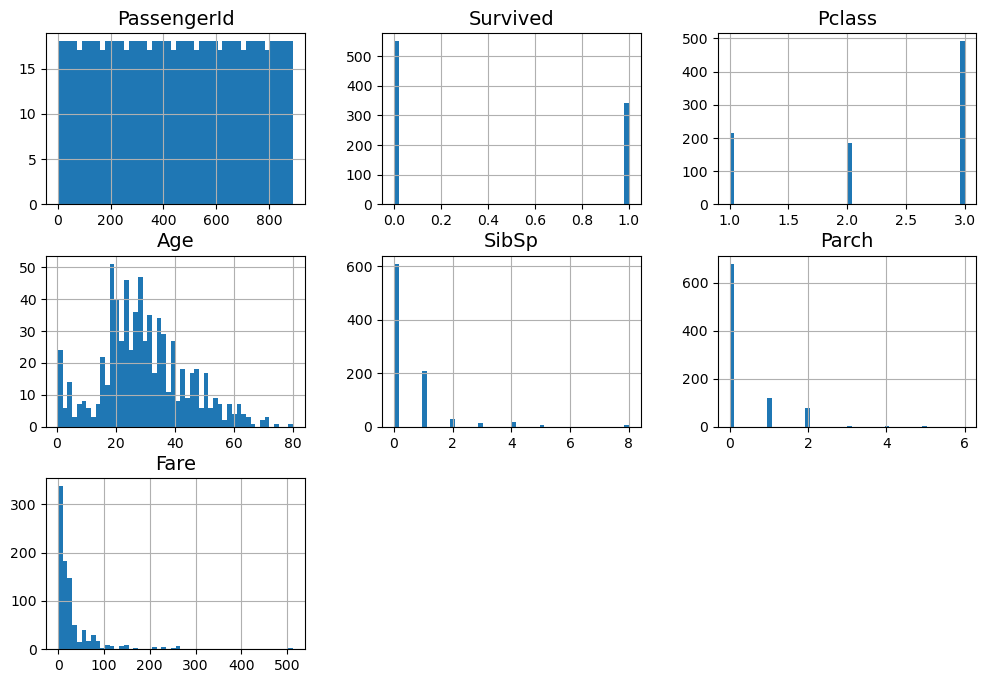

In [13]:
train_copy_pd.hist(bins=50,figsize=(12,8))

In [14]:
#studying the attributes

train_copy_pd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<b>categorical data <br>
Sex  <br>
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd -> Categorical <br>
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton </b>

In [15]:
def nan_columns(df):
    ans=[]
    for column in df.columns:
        if df[column].isna().any():
            ans.append(column)
    return ans
        

In [16]:
nan_columns(train_copy_pd)

['Age', 'Cabin', 'Embarked']

In [17]:
# NaN balues in "Age", "Cabin", "Embarked"
#categorical data-> Sex, pClass, embarked port

In [18]:
corr_matrix=train_copy_pd.corr(numeric_only=True)

In [19]:
corr_matrix["Survived"].sort_values(ascending=True)

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

In [20]:
#As p class increases, the likelihood of survival slightly dec
#As age inc, likelihood of survival dec
#passengers with more siblings had less chance of survival
#Passenger id has close to no affect on the survival rate
#Passengers with more parents/children have a better chance at survival
# Passengers with higher fare have a better chance of survival

## Preparing the data

In [21]:
#extract title from name


def extract_title(name):
    str=name.split(" ")
    # print(str)
    for st in str:
        if st.endswith('.'):
            return st
    return None
    
# extract_title("Braund, Mr. Owen Harris")

In [22]:
train_copy_pd["title"]=train_copy_pd["Name"].apply(extract_title)
train_copy_pd.drop(columns=["Name","Survived"],inplace=True)


In [23]:
test_copy_pd=test_pd_data.copy()

In [24]:
test_copy_pd["title"]=test_copy_pd["Name"].apply(extract_title)
test_copy_pd.drop(columns=["Name"],inplace=True)

In [25]:
# train_copy_pd.drop(columns=["Survived"],inplace=True)

In [26]:
train_copy_pd["title"].value_counts()

title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: int64

In [27]:
len(train_copy_pd["Cabin"].notna()==True)

891

In [28]:
# X_train.shape #890 cols and 12 features

In [29]:
# train_copy_pd["Cabin"].value_counts()

In [30]:
# dealing with the cabin attribute
def extract_cabin(cabin):
    if isinstance(cabin,str):
        return cabin[0]
    
        
train_copy_pd["Cabin_Dept"]=train_copy_pd["Cabin"].apply(extract_cabin)
train_copy_pd["Cabin_Dept"].value_counts()
#use one hot encoding later on

Cabin_Dept
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [31]:
test_copy_pd["Cabin_Dept"]=test_copy_pd["Cabin"].apply(extract_cabin)
test_copy_pd.drop(columns=["Cabin"],inplace=True)

In [32]:
train_copy_pd.drop(columns=["Cabin"],inplace=True)

In [33]:
train_copy_pd["Ticket"].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [34]:
train_copy_pd.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title,Cabin_Dept
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr.,None
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs.,C
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.,None
3,4,1,female,35.0,1,0,113803,53.1000,S,Mrs.,C
4,5,3,male,35.0,0,0,373450,8.0500,S,Mr.,None


In [35]:
#Age, Embarked and Cabin Dept contain Nan values
#categorical data 
# Sex 
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd 
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton 

In [36]:
#>266 -> B
#drop_cab[(drop_cab["Fare"]>140) & (drop_cab["Fare"]<266) & (drop_cab["Embarked"]=="S")] -> C
#train_droptk[(train_droptk["Fare"]>220.3375)&(train_droptk["Fare"]<228.3375)] -> C


#### let's try a model

In [37]:
#taking care of the numerical data
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
    
])

In [38]:
#for categorical attributes
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
cat_pipeline=Pipeline([
    ("ordinal_encoder",OrdinalEncoder()),
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("cat_encoder",OneHotEncoder(sparse_output=False))
])

In [39]:
from sklearn.compose import ColumnTransformer
num_attri=["Age","SibSp","Parch","Fare"]
cat_attri=["Pclass","Sex","Embarked","Cabin_Dept"]

preprocess_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_attri),
    ("cat",cat_pipeline,cat_attri)
])

In [40]:
X_train=preprocess_pipeline.fit_transform(train_copy_pd)

In [41]:
X_train.shape
train_copy_pd.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'title', 'Cabin_Dept'],
      dtype='object')

In [42]:
y_train=train_pd_data["Survived"]

In [43]:
#fitting 

In [82]:
from sklearn.model_selection import cross_val_score
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.823832709113608

In [91]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_clf.fit(X_train, y_train)


SVC(gamma='auto')

In [92]:
y_trainp=svm_clf.predict(X_train)
accuracy_score(y_train,y_trainp)

0.8282828282828283

In [93]:
X_test = preprocess_pipeline.transform(test_copy_pd)


In [94]:
y_pred = svm_clf.predict(X_test)
y_pred.shape
y_pred.shape

(418,)

In [95]:
Id = range(1, len(y_pred) + 1)
my_submission = pd.DataFrame({'PassengerId': test_pd_data.PassengerId, 'Survived': y_pred})

In [96]:
my_submission.to_csv('submission_titanic_1.csv', index=False)

In [ ]:
#score: .78468